In [20]:
import sys
sys.path.append('../')

import jax
jax.config.update("jax_enable_x64", True)

from jax import vmap
import jax.numpy as jnp
import matplotlib.pyplot as plt
from src.signalprocessing import F
from src.particles import array_to_density_feature, array_to_potential_feature, array_to_features, potential_from_vec
from src.dataprocessing import create_padding_mask, pad_data

In [21]:
data_dict = jnp.load('raw_data.npy', allow_pickle=True).item()
data_array = data_dict['data']
N = data_dict['info']['num_points']

training_data = [(array_to_features(x, array_to_potential_feature),y) for (x,y) in data_array]

x_train_pad, y_train_pad = pad_data(training_data)
x_train_pad = x_train_pad.astype(jnp.float64)
mask_train_pad = create_padding_mask(jnp.linalg.norm(x_train_pad, axis=2))

train_data_final = {'x': x_train_pad, 'y': y_train_pad, 'mask': mask_train_pad}
jnp.save('train_data.npy', train_data_final)

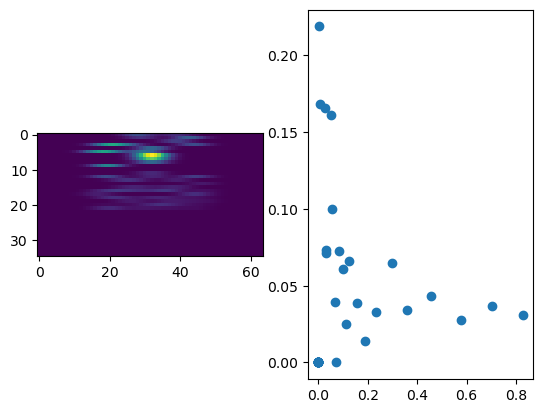

In [37]:


def potential_from_real_feature(x0, x):
    f = x[:-2]
    f = F(f)
    c, w = x[-2], x[-1]
    #t = jnp.linspace(c-w/2, c+w/2, len(f)+1)[:-1]
    #return jnp.sum(f * 1/jnp.abs(x0 - t))
    return potential_from_vec(x0, jnp.concatenate([f, jnp.array([c, w])]))

def potential_from_real_features(x0, x, mask):
    contributions = vmap(lambda x: potential_from_real_feature(x0, x))(x)   
    return jnp.sum(jnp.where(mask, contributions, 0), axis=0)


idx = 8

plt.subplot(121)
plt.imshow(x_train_pad[idx,:,:-2])#, vmin=-1, vmax=1)

plt.subplot(122)
plt.scatter(jnp.abs(x_train_pad[idx,:,-2]), vmap(jnp.linalg.norm)(x_train_pad[idx,:,:-2]))